In [108]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.forward_ad as fwAD
import functorch

# For datasets
import torchvision
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings("ignore")

## **FORWARD GRADIENT**
Given a function $f:\mathbb{R}^n\to\mathbb{R}$, the forward gradient $\mathbf{g}:\mathbb{R}^n\to\mathbb{R}^n$ is defined as:
$$\mathbf{g}_\mathbf{v}(x):= \nabla_\mathbf{v} f(x)\cdot\mathbf{v}=(\nabla f(x)\cdot\mathbf{v})\mathbf{v}$$
where $x\in\mathbb{R}^n$ is the point at which we are evaluating
the gradient, $\mathbf{v}\in\mathbb{R}^n$ is a perturbation vector taken as a multivariate random variable $\mathbf{v}\backsim p(\mathbf{v})$ such that $\mathbf{v}$’s scalar components $v_i$ are independent and have zero mean and unit variance for all $i$, and $\nabla f(x)\cdot\mathbf{v}\in\mathbb{R}$ is the directional
derivative of $f$ at point $x$ in direction $\mathbf{v}$.

Moreover, the *forward gradient* $\mathbf{g}_\mathbf{v}(x)$ is an unbiased estimator of the gradient $\nabla f(x)$.

##### **Example [1.1]**
Let's try to perform **forward gradient descent** using the *forward gradients*:

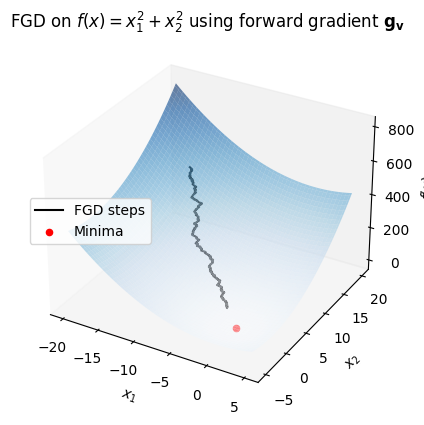

In [104]:
# Define the function
def f1(x1, x2):
    return x1**2 + x2**2

# Define x1, x2, primals and v as canonic base
x1 = torch.tensor([-15.])
x2 = torch.tensor([15.])
primals = (x1, x2)
v_canonic = [(torch.ones(1), torch.zeros(1)), (torch.zeros(1), torch.ones(1))]

# Define learning rate and number of epochs
l_rate = 0.01
epochs = 1000

# Initialize list of x values, fwd grads and true grads:
x_values = list()
fwd_grads = list()
true_grads = list()

# Perform FDG (forward gradient descent)
for i in range(epochs):
    # Sample perturbation
    v_params = tuple([torch.rand_like(p) for p in primals])
    # Compute f and df
    _, jvp = functorch.jvp(f1, primals, v_params)
    # Parameters update using forward gradient
    x_values.append([p.sub_(l_rate * jvp * v_params[j]).item() for j, p in enumerate(primals)])
    # Save true gradients and fwd gradients
    fwd_grads.append([jvp * v_params[j] for j, p in enumerate(primals)])
    true_grads.append([functorch.jvp(f1, primals, v)[1].item() for v in v_canonic])

# Transform to numpy lists
x_values = np.array(x_values)
fwd_grads = np.array(fwd_grads)
true_grads = np.array(true_grads)

# Define the parameters for the plot
t1 = np.linspace(-20, 5, 100)
t2 = np.linspace(-5, 20, 100)
T1, T2 = np.meshgrid(t1, t2)

# Create a plot, disable grid, and add a title
ax = plt.axes(projection='3d')
ax.grid(False)
plt.title(r"FGD on $f(x)=x_1^2+x_2^2$ using forward gradient $\mathbf{g}_\mathbf{v}$")

# Plot f, GD steps and minima
ax.plot_surface(T1, T2, f1(T1, T2), cmap='Blues', alpha=0.6)
ax.plot(x_values[:, 0], x_values[:, 1], f1(*x_values.T), '-', color='black', label="FGD steps", alpha=1)
ax.scatter(0, 0, 0, color='r', label='Minima')

# Add labels and legend
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$f(x)$')
plt.legend(loc='center left')
plt.show()

As can be seen from the graph, although noisily, the forward gadient descent algorithm manages to converge at a minimum.
Let us now actually analyze how far the forward gradient approximation deviates from the true value:

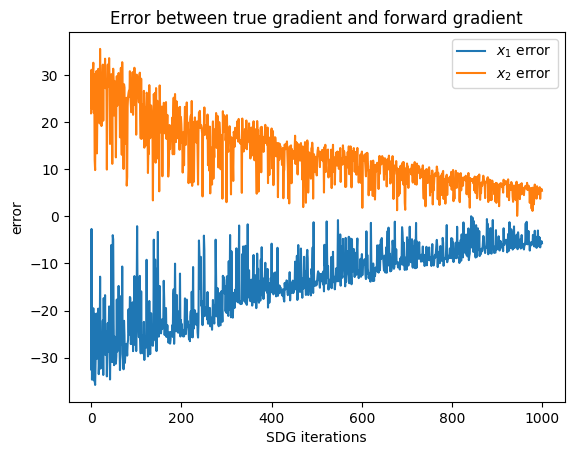

In [105]:
plt.plot(true_grads[:,0]-fwd_grads[:,0], label=r'$x_1$ error')
plt.plot(true_grads[:,1]-fwd_grads[:,1], label=r'$x_2$ error')

plt.title(r"Error between true gradient and forward gradient")
plt.xlabel(r'SDG iterations')
plt.ylabel('error')
plt.legend()
plt.show()

As can be seen from the graph, as the minimum of the function is approached, the difference between the forward gradient and the true gradient of the function is reduced.

---

Let's now try to apply the forward gradient to a CNN.

In [109]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [111]:
# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

# Define bathc size
batch_size = 32

# Create data dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [115]:
def loss_fn(params, model, x, t, num_classes):
    y = model(params, x)
    probs = torch.softmax(x)
    eps = torch.finfo(probs.dtype).eps
    y = probs.clamp(min=eps, max=1 - eps)
    logy = -torch.log(y)
    loss = torch.mean(torch.sum(logy * F.one_hot(t, num_classes), dim=1))
    return loss

In [118]:
net = LeNet()
criterion = nn.CrossEntropyLoss()
lr = 0.001

# Get the functional version of the model with functorch
fmodel, params = functorch.make_functional(net)

# Train the network
num_epochs = 10
for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        
        v = tuple([torch.randn_like(p) for p in params])

        # Forward AD
        loss, jvp = functorch.jvp(loss_fn(params, net, inputs, labels, len(train_dataset.classes)), (tuple(params),), (v,))

        # Parameters update
        [p.sub_(lr * jvp * v_params[j]) for j, p in enumerate(params)]

        if i % 100 == 99: print(f'[Epoch {epoch}, Mini-batch {i}] loss: {loss}')

print('Finished Training')

TypeError: forward() takes 2 positional arguments but 3 were given

### References

[1] [Derivative](https://en.wikipedia.org/wiki/Derivative).

[2] Kofi Asiedu Brempong, 2020 [I Finally Understood Backpropagation: And you can too...](https://towardsdatascience.com/i-finally-understood-backpropagation-and-you-can-too-44f7dd98ff52).

[3] Atılım Gunes Baydin, Barak A. Pearlmutter, Don Syme, Frank Wood, Philip Torr, 2022. [Gradients without Backpropagation](https://arxiv.org/abs/2005.00817).

[4] [Dual number](https://en.wikipedia.org/wiki/Dual_number).

[5] Mark Saroufim, 2019. [Automatic Differentiation Step by Step](https://marksaroufim.medium.com/automatic-differentiation-step-by-step-24240f97a6e6).

[6] Robert Lange, 2019. [Forward Mode Automatic Differentiation & Dual Numbers](https://towardsdatascience.com/forward-mode-automatic-differentiation-dual-numbers-8f47351064bf).

[7] [Automatic Differentiation in Machine Learning: a Survey](https://www.jmlr.org/papers/volume18/17-468/17-468.pdf).

[8] Daniel Worrall, 2021. [Dual numbers](https://danielewworrall.github.io/blog/2021/08/dual-numbers/)

[9] Dr. Robert Kübler, 2022. [Papers Simplified: Gradients without Backpropagation](https://towardsdatascience.com/papers-simplified-gradients-without-backpropagation-96e8533943fc).